# Neutral Networks from Scratch and CNN 4



Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random

Reading images with opencv

In [2]:
DATADIR = "C:/Users/90552/Desktop/animals/raw-img"

CATEGORIES = ["cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora", "ragno", "scoiattolo"]
IMG_SIZE = 50
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num+1])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

100%|██████████| 1862/1862 [00:00<00:00, 2135.32it/s]


In [4]:
print("Lenght of the Data: " + str(len(training_data)))
random.shuffle(training_data)
print("Class Distribution")
for sample in training_data[:20]:
    print(sample[1])

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE) #converting into numpy array

Lenght of the Data: 26179
Class Distribution
5
3
1
1
2
9
2
10
1
9
7
9
7
7
9
3
9
7
1
2


In [6]:
list = []
for x in X:
  list.append(x.flatten()) #flatten data

data = np.array(list)
m, n = data.shape
y = np.array(y)

y1 = y
y1 = (y1[:,None] == np.arange(y1.max())+1).astype(int) # convert labels to [0 0 0 0 1 0 0 0 0 0] 
print(y1[0])


data_t = data.T
num = round(data[:, 0].size*0.8)
train1, test1 = data[:num,:], data[num:,:]

train = train1 / 255 #normalize data
test = test1 / 255 #normalize data

train_label, test_label = y1[:num], y1[num:]
print(test_label.shape)

[0 0 0 0 1 0 0 0 0 0]
(5236, 10)


Activation functions

In [5]:
def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    expX = np.exp(x)
    return expX/np.sum(expX, axis = 0)

and its derivatives

In [6]:
def derivative_tanh(x):
    return (1 - np.power(np.tanh(x), 2))

def derivative_relu(x):
    return np.array(x > 0, dtype = np.float32)

Initilazing parameters with np.random

In [7]:
def initialize_parameters(n_x, n_h, n_y):
    w1 = np.random.randn(n_h, n_x)*0.01
    #w1 = np.random.uniform(-0.5, 0.5, (n_h, n_x))
    b1 = np.zeros((n_h, 1))
    
    w2 = np.random.randn(n_y, n_h)*0.01
    #w2 = np.random.uniform(-0.5, 0.5, (n_y, n_h))
    b2 = np.zeros((n_y, 1))
    
    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }
    
    return parameters

The input provides the initial information that then propagates to the hidden units at each layer and finally produce the output 

In [8]:
def forward_propagation(x, parameters, activation):
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    z1 = np.dot(w1, x) + b1
    
    if(activation == 'relu'):
        a1 = relu(z1)
    else:
        a1 = tanh(z1)
    
    
    z2 = np.dot(w2, a1) + b2
    a2 = softmax(z2)
    
    forward_cache = {
        "z1" : z1,
        "a1" : a1,
        "z2" : z2,
        "a2" : a2
    }
    
    return forward_cache

Calculates negative log-likelilood

In [9]:
def cost_function(a2, y, batch_size):
    m = batch_size #y.shape[1]
    
    cost = -(1/m)*np.sum(y*np.log(a2))
    
    #cost = -(1/m)*np.sum(np.sum(y*np.log(a2, 0), 1))
    
    return cost

Calculates dw and db

In [10]:
def backward_prop(x, y, parameters, forward_cache, activation):
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    a1 = forward_cache['a1']
    a2 = forward_cache['a2']
    
    m = x.shape[1]
    
    dz2 = (a2 - y)
    dw2 = (1/m)*np.dot(dz2, a1.T)
    db2 = (1/m)*np.sum(dz2, axis = 1, keepdims = True)
    
    if(activation == 'relu'):
        dz1 = (1/m)*np.dot(w2.T, dz2)*derivative_relu(a1)
    else:
        dz1 = (1/m)*np.dot(w2.T, dz2)*derivative_tanh(a1)
    
    
    dw1 = (1/m)*np.dot(dz1, x.T)
    db1 = (1/m)*np.sum(dz1, axis = 1, keepdims = True)
    
    gradients = {
        "dw1" : dw1,
        "db1" : db1,
        "dw2" : dw2,
        "db2" : db2
    }
    
    return gradients

Updating parameters

In [11]:
def update_parameters(parameters, gradients, learning_rate):
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    dw1 = gradients['dw1']
    db1 = gradients['db1']
    dw2 = gradients['dw2']
    db2 = gradients['db2']
    
    w1 = w1 - learning_rate*dw1
    b1 = b1 - learning_rate*db1
    w2 = w2 - learning_rate*dw2
    b2 = b2 - learning_rate*db2
    
    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }
    
    return parameters

Builds the neural network model

In [12]:
def model(x, y, n_h, learning_rate, iterations, batch_size, activation):
    
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    cost_list = []
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    print("Iterations: ", iterations, "\n"
          "Learning Rate: ",learning_rate, "\n"
         "Batch Size: ",batch_size, "\n"
         "Activation: ",activation, "\n"
         "Hidden Layer Neuron Count: ",n_h, "\n")
    for i in range(iterations):
        
        forward_cache = forward_propagation(x, parameters, activation)
        
        cost = cost_function(forward_cache['a2'], y, batch_size)
        
        gradients = backward_prop(x, y, parameters, forward_cache, activation)
        
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        cost_list.append(cost)
        
        if(i%(iterations/5) == 0):
            print("Cost after", i, "iterations is:", round(cost, 3))
    print("Cost after", iterations, "iterations is:", round(cost, 3))
    return parameters, cost_list

In [14]:
def accuracy(inp, labels, parameters, activation):
    forward_cache = forward_propagation(inp, parameters, activation)
    a_out = forward_cache['a2']   # containes propabilities with shape(10, 1)
    
    a_out = np.argmax(a_out, 0)  # 0 represents row wise 
    
    labels = np.argmax(labels, 0)
    
    acc = np.mean(a_out == labels)*100
    
    return round(acc,2)

In [15]:
Parameters, Cost_list = model(train.T, train_label.T,128, 0.02, 100, 128, "relu")
print("Accuracy of Train Dataset", accuracy(train.T, train_label.T, Parameters, relu), "%")
print("Accuracy of Test Dataset", round(accuracy(test.T, test_label.T, Parameters, relu), 2), "%", "\n")

Parameters, Cost_list = model(train.T, train_label.T,128, 0.01, 100, 128, "relu")
print("Accuracy of Train Dataset", accuracy(train.T, train_label.T, Parameters, relu), "%")
print("Accuracy of Test Dataset", round(accuracy(test.T, test_label.T, Parameters, relu), 2), "%", "\n")

Parameters, Cost_list = model(train.T, train_label.T,128, 0.005, 100, 128, "relu")
print("Accuracy of Train Dataset", accuracy(train.T, train_label.T, Parameters, relu), "%")
print("Accuracy of Test Dataset", round(accuracy(test.T, test_label.T, Parameters, relu), 2), "%", "\n")

Parameters, Cost_list = model(train.T, train_label.T,16, 0.02, 100, 128, "relu")
print("Accuracy of Train Dataset", accuracy(train.T, train_label.T, Parameters, relu), "%")
print("Accuracy of Test Dataset", round(accuracy(test.T, test_label.T, Parameters, relu), 2), "%", "\n")

Parameters, Cost_list = model(train.T, train_label.T,64, 0.02, 100, 128, "relu")
print("Accuracy of Train Dataset", accuracy(train.T, train_label.T, Parameters, relu), "%")
print("Accuracy of Test Dataset", round(accuracy(test.T, test_label.T, Parameters, relu), 2), "%", "\n")

Parameters, Cost_list = model(train.T, train_label.T,128, 0.02, 100, 128, "relu")
print("Accuracy of Train Dataset", accuracy(train.T, train_label.T, Parameters, relu), "%")
print("Accuracy of Test Dataset", round(accuracy(test.T, test_label.T, Parameters, relu), 2), "%", "\n")

Parameters, Cost_list = model(train.T, train_label.T,128, 0.02, 100, 64, "relu")
print("Accuracy of Train Dataset", accuracy(train.T, train_label.T, Parameters, relu), "%")
print("Accuracy of Test Dataset", round(accuracy(test.T, test_label.T, Parameters, relu), 2), "%", "\n")

Parameters, Cost_list = model(train.T, train_label.T,128, 0.02, 100, 128, "relu")
print("Accuracy of Train Dataset", accuracy(train.T, train_label.T, Parameters, relu), "%")
print("Accuracy of Test Dataset", round(accuracy(test.T, test_label.T, Parameters, relu), 2), "%", "\n")

Parameters, Cost_list = model(train.T, train_label.T,128, 0.02, 100, 256, "relu")
print("Accuracy of Train Dataset", accuracy(train.T, train_label.T, Parameters, relu), "%")
print("Accuracy of Test Dataset", round(accuracy(test.T, test_label.T, Parameters, relu), 2), "%", "\n")

Parameters, Cost_list = model(train.T, train_label.T,128, 0.005, 100, 128, "tanh")
print("Accuracy of Train Dataset", accuracy(train.T, train_label.T, Parameters, relu), "%")
print("Accuracy of Test Dataset", round(accuracy(test.T, test_label.T, Parameters, relu), 2), "%" )

Iterations:  100 
Learning Rate:  0.02 
Batch Size:  128 
Activation:  relu 
Hidden Layer Neuron Count:  128 

Cost after 0 iterations is: 376.283
Cost after 20 iterations is: 371.725
Cost after 40 iterations is: 368.392
Cost after 60 iterations is: 365.992
Cost after 80 iterations is: 364.284
Cost after 100 iterations is: 363.125
Accuracy of Train Dataset 19.63 %
Accuracy of Test Dataset 20.11 % 

Iterations:  100 
Learning Rate:  0.01 
Batch Size:  128 
Activation:  relu 
Hidden Layer Neuron Count:  128 

Cost after 0 iterations is: 376.733
Cost after 20 iterations is: 373.701
Cost after 40 iterations is: 371.196
Cost after 60 iterations is: 369.142
Cost after 80 iterations is: 367.466
Cost after 100 iterations is: 366.167
Accuracy of Train Dataset 18.6 %
Accuracy of Test Dataset 18.47 % 

Iterations:  100 
Learning Rate:  0.005 
Batch Size:  128 
Activation:  relu 
Hidden Layer Neuron Count:  128 

Cost after 0 iterations is: 376.715
Cost after 20 iterations is: 375.09
Cost after 40

##### *Learning Rate*

| Learning Rate | Accuracy Train | Accuracy Test |
| :- | :-: | :-: |
| 0.02 | 19.63 % | 20.11 % |
| 0.01 | 18.6 %  | 18.47 %  |
| 0.005 | 18.46 %  | 18.18 %  |

Decreasing learning rate to much doesnt help. Around 0.02 looks great

##### *Hidden Layer Neuron Count*

| HLNC | Accuracy Train | Accuracy Test |
| :- | :-: | :-: |
| 16 | 18.59 % | 18.58 %  |
| 64 | 18.83 %  | 18.93 %   |
| 128 | 20.16 %  | 19.79 %   |

Increasing neuron count gives better accuracy. But increasing to much will not great because of high compution time. It can also cause to overfitting.

##### *Batch Size*

| batch _size | Accuracy Train | Accuracy Test |
| :- | :-: | :-: |
| 64 | 18.4 % | 17.93 %|
| 128 | 18.55 %  | 18.2 % |
| 256 | 18.44 %  | 18.09 % |

Batch size has no effect on accuracy

##### *Activation Function*

| Act. Func. | Accuracy Train | Accuracy Test |
| :- | :-: | :-: |
| relu | 19.63 % | 20.11 % |
| tanh | 19.57 %  | 20.0 % |

For both activation function accuracies are similar

# Part 2: Convolutional Neural Network

Imports

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

Creating train and test datasets folders

In [4]:
os.mkdir('C:/Users/90552/Desktop/animals/train/') 
for img_class in os.listdir("C:/Users/90552/Desktop/animals/raw-img/"):
    os.mkdir('C:/Users/90552/Desktop/animals/train/' + img_class + '/')

#test folders
os.mkdir('C:/Users/90552/Desktop/animals/test/')
for img_class in os.listdir("C:/Users/90552/Desktop/animals/raw-img/"):
    os.mkdir('C:/Users/90552/Desktop/animals/test/' + img_class + '/')

#train dataset
for img_class in tqdm(os.listdir('C:/Users/90552/Desktop/animals/train/')):
    img_ls = os.listdir("C:/Users/90552/Desktop/animals/raw-img/" + img_class)
    for img in img_ls[:int(len(img_ls) * 0.8)]:

        shutil.copy("C:/Users/90552/Desktop/animals/raw-img/" + img_class + '/' + img,
                    'C:/Users/90552/Desktop/animals/train/' + img_class + '/' + img)


#test dataset
for img_class in tqdm(os.listdir('C:/Users/90552/Desktop/animals/test/')):
    img_ls = os.listdir("C:/Users/90552/Desktop/animals/raw-img/" + img_class)
    for img in img_ls[int(len(img_ls) * 0.8):]:

        shutil.copy("C:/Users/90552/Desktop/animals/raw-img/" + img_class + '/' + img,
                    'C:/Users/90552/Desktop/animals/test/' + img_class + '/' + img)

train_data_path = 'C:/Users/90552/Desktop/animals/train/'
test_data_path = 'C:/Users/90552/Desktop/animals/test/'

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Transform images to tensors them load them with batch size 64

In [5]:
from torchvision import transforms

transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

# this function get folder with images
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=transforms)

test_data = torchvision.datasets.ImageFolder(root=test_data_path,
                                             transform=transforms)

# %% [code]
batch_size=64
train_data_loader = data.DataLoader(train_data, shuffle=True,
                                    batch_size=batch_size)

test_data_loader  = data.DataLoader(test_data, shuffle=True,
                                    batch_size=batch_size)

Loading the pretrained model and finetuning, layer size changed to 25088-512-10. 10 is output layer

For part2.1 all layers finetuned

In [6]:
from torchvision import models
transfer_model = torchvision.models.vgg19(pretrained=True)
print(transfer_model)

for name, param in transfer_model.named_parameters(): #finetune all layers
    print(name)
    param.requires_grad = True
    
#transfer_model.classifier = nn.Linear(25088,10)
transfer_model.classifier = nn.Sequential(nn.Linear(25088,512),
                                nn.ReLU(),
                                nn.Linear(512,10))
print(transfer_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Check if cuda available and set up optimizer. Adam optimizer is used

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = transfer_model
model.to(device)
# add optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0003, amsgrad=True)
epochs = 3
loss_fn = torch.nn.CrossEntropyLoss()
loss_lst, loss_val_lst = [], []

Calculate accuracy, training loss, validation loss

In [8]:
def calc_acc(epochs):    
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_data_loader:
            optimizer.zero_grad()
            inputs, target = batch
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)

            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item()
        loss_lst.append(training_loss)

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in test_data_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets)
            valid_loss += loss.data.item()
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1],
                            targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        loss_val_lst.append(valid_loss)

        print('Epoch: {}, Training Loss: {:.2f}, \
            Validation Loss: {:.2f}, \
            Accuracy = {:.2f}'.format(epoch, training_loss, \
            valid_loss, num_correct / num_examples))

In [9]:
calc_acc(2)

<ipython-input-8-ec95b1a9cf82>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1],


Epoch: 0, Training Loss: 435.33,             Validation Loss: 83.46,             Accuracy = 0.65
Epoch: 1, Training Loss: 238.39,             Validation Loss: 57.09,             Accuracy = 0.78


Finetune fully connected layers

In [10]:
for name, param in transfer_model.named_parameters():
    if(name == "classifier.0.weight" or "classifier.3.weight"): #if fully connected
        param.requires_grad = True
    else:
        param.requires_grad = False

loss_fn = torch.nn.CrossEntropyLoss()
loss_lst, loss_val_lst = [], []
calc_acc(2)

<ipython-input-8-ec95b1a9cf82>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1],


Epoch: 0, Training Loss: 152.88,             Validation Loss: 48.87,             Accuracy = 0.82
Epoch: 1, Training Loss: 103.57,             Validation Loss: 42.16,             Accuracy = 0.84


## Pros and Cons of Finetuning

Pros:

Reduced training time. By using pre-trained weights, the model's first few layers are already very effective. You just need to train the final layers of your model.

Improved performance. Models you usually used are pre-trained on large scale datasets. Because CNNs performance improves with more training data, the lower-level filters of pre-trained models are probably superior to filters trained on smaller datasets.

Counter over-fitting on small datasets.

Cons:

No guarantee that the initialization point of the weights is a good starting point; they could be stuck in a local minimum.

Restricted architecture. The most important downside of using pre-trained models are that we are restricted to use exactly the same architecture, which might not be desirable. The good thing is that pre-trained weights are available for almost all state-of-the-art models.

### Finetuning all layers vs only fully connected layers
Due to limited memory, I can achieve only 2 epochs

Finetuning all layers

| Epochs | Training Loss | Validation Loss | Accuracy |
| :- | :-: | :-: | :-: |
| Epoch 0 | 435.33 | 83.46 | 0.65 |
| Epoch1 | 238.39  | 57.09 | 0.78  |

Finetuning fully connected layers

| Epochs | Training Loss | Validation Loss | Accuracy |
| :- | :-: | :-: | :-: |
| Epoch 0 | 152.88 | 48.87 | 0.82 |
| Epoch1 | 103.57  | 42.16 | 0.84  |

Finetuning fully connected layers gives us a better results from all persfectives. Less train and validation loss and much better accuracy.

Plotting heat-map

100%|██████████| 82/82 [00:21<00:00,  3.90it/s]


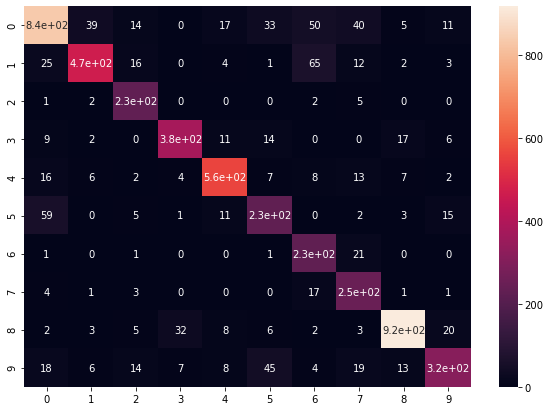

In [11]:
all_output = np.array([])
all_targets = np.array([])

for batch in tqdm(test_data_loader):
    inputs, targets = batch
    inputs = inputs.to(device)
    output = model(inputs)
    all_output = np.concatenate([all_output, output.max(dim=1).indices.cpu().numpy()])
    all_targets = np.concatenate([all_targets, targets.numpy()])

# %% [code]
# plot confusion matrix
conf_matr = confusion_matrix(all_output,
                             all_targets)
plt.figure(figsize = (10,7))
sns.heatmap(conf_matr, annot=True);

Other metric scores

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(all_output, all_targets, average='macro'))
print("Recall:", recall_score(all_output, all_targets, average='macro'))
print("F1 score:", f1_score(all_output, all_targets, average='macro'))

Precision: 0.8105543963402739
Recall: 0.8434047085766144
F1 score: 0.8205578583919093


## Neural Network vs CNN

Neural Network use one perceptron for each input (e.g. pixel in an image) and the amount of weights rapidly becomes unmanageable for large images. It includes too many parameters because it is fully connected. Each node is connected to every other node in next and the previous layer, forming a very dense web — resulting in redundancy and inefficiency. As a result, difficulties arise whilst training and overfitting can occur which makes it lose the ability to generalize.

Another common problem is that MLPs react differently to an input (images) and its shifted version — they are not translation invariant. For example, if a picture of a cat appears in the top left of the image in one picture and the bottom right of another picture, the MLP will try to correct itself and assume that a cat will always appear in this section of the image.
Hence, MLPs are not the best idea to use for image processing. One of the main problems is that spatial information is lost when the image is flattened(matrix to vector) into an MLP.

We thus need a way to leverage the spatial correlation of the image features (pixels) in such a way that we can see the cat in our picture no matter where it may appear.

The main purpose of the convolution step is to extract features from the input image. The convolutional layer is always the first step in a CNN.

You have an input image, a feature detector, and a feature map. You take the filter and apply it pixel block by pixel block to the input image. You do this through the multiplication of the matrices.

For this reasons CNN is prefrred over Neural Network for image classification. From our experiment, neural network gives low accuracy but our VGG-19 has a over %80 accuracy